# **Exercise on Smarket data: practice on financial data**
In this lab we will examine the Smarket data, which is part of the ISLP library. This data set consists of percentage returns for the S&P 500 stock index over 1,250 days, from the beginning of 2001 until the end of 2005. For each date, we have recorded the percentage returns for each of the five previous trading days, `Lag1` through `Lag5`. We have also recorded `Volume` (the number of shares traded on the previous day, in billions), `Today` (the percentage return on the date in question) and `Direction` (whether the market was Up or Down on this date).

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots 
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,summarize)

In [2]:
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

Now we are ready to load the `Smarket` data.

In [3]:
Smarket = load_data('Smarket') 
Smarket

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...,...
1245,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1246,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1247,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up
1248,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down


We can see what the variable names are.

In [4]:
Smarket.columns

Index(['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today',
       'Direction'],
      dtype='object')

We compute the correlation matrix using the `corr()` method for data frames, which produces a matrix that contains all of the pairwise correlations among the variables. 

In [6]:
Smarket_drop = Smarket.loc[:, Smarket.columns != 'Direction'] #drop the qualitative column
Smarket_drop.corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


As one would expect, the correlations between the lagged return variables and today’s return are close to zero. The only substantial correlation is between `Year` and `Volume`. By plotting the data we see that `Volume` is increasing over time. In other words, the average number of shares traded daily increased from 2001 to 2005.

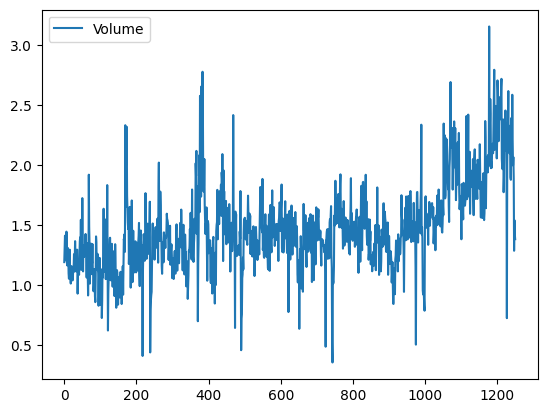

In [7]:
Smarket.plot(y='Volume');

Train a logistic regression model by the observations from 2001 through 2004, with Lags and volume. Then use this model to predict market directions from 2005.

In [8]:
train = (Smarket.Year < 2005) 
Smarket_train = Smarket.loc[train] 
Smarket_test = Smarket.loc[~train] 
Smarket_test.shape

(252, 9)

In [9]:
#obtain the feature matrix and label vector
allvars = Smarket.columns.drop(['Today', 'Direction', 'Year']) 
design = MS(allvars)
X = design.fit_transform(Smarket)
y = Smarket.Direction == 'Up'

In [10]:
#split data to training and test sets
X_train, X_test = X.loc[train], X.loc[~train] 
y_train, y_test = y.loc[train], y.loc[~train] 
glm_train = sm.GLM(y_train,X_train ,family=sm.families.Binomial()) 
results = glm_train.fit()
probs = results.predict(exog=X_test)

In [11]:
summarize(results)

,coef,std err,z,P>|z|
intercept,0.1912,0.334,0.573,0.567
Lag1,-0.0542,0.052,-1.046,0.295
Lag2,-0.0458,0.052,-0.884,0.377
Lag3,0.0072,0.052,0.139,0.889
Lag4,0.0064,0.052,0.125,0.901
Lag5,-0.0042,0.051,-0.083,0.934
Volume,-0.1163,0.240,-0.485,0.628


The smallest p-value here is associated with `Lag1`. The negative coefficient for this predictor suggests that if the market had a positive return yesterday, then it is less likely to go up today. However, at a value of 0.30, the p-value is still large, and so there is no statistical evidence of a real association between `Lag1` and `Direction`.

Notice that we have trained and tested our model on two completely separate data sets: training was performed using only the dates before 2005, and testing was performed using only the dates in 2005.
Finally, we compare the predictions for 2005 to the actual movements of the market over that time period. We will first store the test and training labels (recall y_test is binary).

In [12]:
D = Smarket.Direction
L_train, L_test = D.loc[train], D.loc[~train]

Now we threshold the fitted probability at 50% to form our predicted labels.

In [13]:
labels = np.array(['Down']*252) 
labels[probs>0.5] = 'Up' 
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,77,97
Up,34,44


In [14]:
np.mean(labels == L_test), np.mean(labels != L_test)

(0.4801587301587302, 0.5198412698412699)

The test accuracy is about 48% while the error rate is about 52%

We recall that the logistic regression model had very underwhelming p-values associated with all of the predictors, and that the smallest p-value, though not very small, corresponded to `Lag1`. Perhaps by removing the variables that appear not to be helpful in predicting `Direction`, we can obtain a more effective model. After all, using predictors that have no relationship with the response tends to cause a deterioration in the test error rate (since such predictors cause an increase in variance without a corresponding decrease in bias), and so removing such predictors may in turn yield an improvement. Below we refit the logistic regression using just `Lag1` and `Lag2`, which seemed to have the highest predictive power in the original logistic regression model.

In [15]:
model = MS(['Lag1', 'Lag2']).fit(Smarket)
X = model.transform(Smarket)
X_train, X_test = X.loc[train], X.loc[~train] 
glm_train = sm.GLM(y_train,X_train ,family=sm.families.Binomial()) 
results = glm_train.fit()
probs = results.predict(exog=X_test) 
labels = np.array(['Down']*252) 
labels[probs>0.5] = 'Up' 
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [16]:
(35+106) /252 ,106/(106+76)

(0.5595238095238095, 0.5824175824175825)

Now the results appear to be a little better: 56% of the daily movements have been correctly predicted. It is worth noting that in this case, a much simpler strategy of predicting that the market will increase every day will also be correct 56% of the time! Hence, in terms of overall error rate, the logistic regression method is no better than the naive approach. However, the confusion matrix shows that on days when logistic regression predicts an increase in the market, it has a 58% accuracy rate. This suggests a possible trading strategy of buying on days when the model predicts an increasing market, and avoiding trades on days when a decrease is predicted. Of course one would need to investigate more carefully whether this small improvement was real or just due to random chance.